In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv('clustering.csv', header=None)

In [4]:
data.head()

,0,1
0,41.788907,52.220182
1,-96.586516,90.957033
2,-54.143591,-99.153377
3,19.929231,-45.859779
4,-82.941076,84.099186


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 2 columns):
0    400 non-null float64
1    400 non-null float64
dtypes: float64(2)
memory usage: 6.4 KB


Ramka zawiera wyłącznie dane numeryczne, nie zawiera braków danych. Zatem nie wymaga czyszczenia.

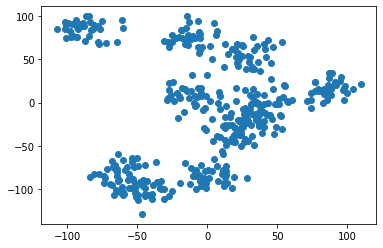

In [6]:
plt.scatter(data.iloc[:, 0], data.iloc[:, 1])

 Widać w danych pewne naturalne podziały, tym nie mniej do jednoznacznego określenia optymalnej ilości klastrów wymagane będzie zastosowanie metryk.

In [7]:
data.describe()

,0,1
count,400.000000,400.000000
mean,-0.580656,-8.010264
std,48.821210,62.096845
min,-107.433649,-128.983720
25%,-34.551495,-70.730416
50%,5.691010,-3.447565
75%,31.456507,45.822610
max,109.733409,99.935839


Chociaż nie widać rażących różnic między rzędami wielkości w kolumnach, aby mieć pewność, że w procesie klasteryzacji, cechy będą traktowane jako równie istotne, można pokusić się o  przetestowanie wpływu ich skalowania.

In [8]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
mms.fit(data)
df_transformed = pd.DataFrame(mms.transform(data))

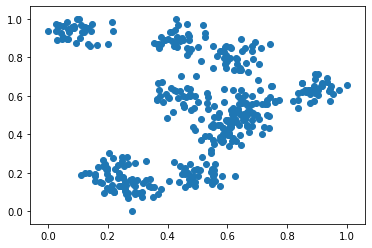

In [9]:
plt.scatter(df_transformed.iloc[:, 0], df_transformed.iloc[:, 1])

Skalowanie nie spowodowało zauważalnych zmian w obrębie naturalnych skupień.

## 1. K-Means

### 1.1. Wyznaczenie optymalnego k

In [10]:
from sklearn.cluster import KMeans

In [11]:
# intuicyjnie inertia może być utożsamiana z odległością między punktami w obrębie klastra
def count_inertia_scores(data, kmax):
    dist = []
    k_range = range(1, kmax+1)
    for k in k_range:
        km = KMeans(n_clusters=k)
        km = km.fit(data)
        dist.append(km.inertia_)
    return dist, k_range

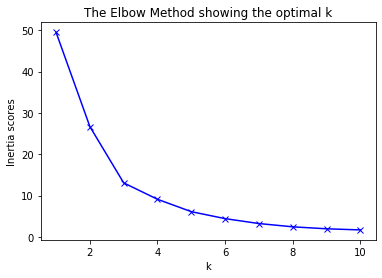

In [12]:
inertia_scores, x_ticks = count_inertia_scores(df_transformed, 10)

plt.plot(x_ticks, inertia_scores, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia scores')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Punkt przegięcia, na powyższym wykresie, występuje dla k = 3.

### 1.2. Model

In [13]:
# Stworzenie k_means_model
kmm = KMeans(n_clusters=3)
# Trenowanie modelu
kmm.fit(df_transformed)
# Predykcja
prediction = kmm.predict(df_transformed)

### 1.3. Graficzne przedstawienie przypisania do klastrów

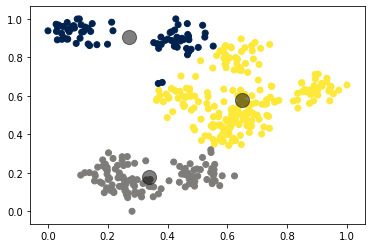

In [14]:
plt.scatter(df_transformed.iloc[:, 0], df_transformed.iloc[:, 1], c=prediction, cmap='cividis')
centers = kmm.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

## 2. Gaussian Mixture Model

In [22]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

### 2.1. Wyznaczenie optymalnego k

In [23]:
def count_silhuette_score(data, kmax):
    scores = []
    k_range = range(2, kmax+1)
    for k in k_range:
        gmm = GaussianMixture(n_components=k)
        gmm.fit(data)
        labels = gmm.predict(data)
        scores.append(silhouette_score(data, labels, metric = 'euclidean'))
    return scores, k_range

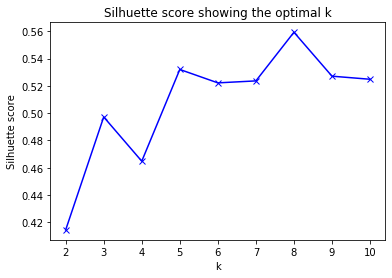

In [24]:
sil_scores, x_ticks = count_silhuette_score(df_transformed, 10)

plt.plot(x_ticks, sil_scores, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhuette score')
plt.title('Silhuette score showing the optimal k')
plt.show()

Miara silhuette osiąga maksimum globalne przy optymalnym k. Tutaj maksimum globalne mamy dla k = 8.

### 2.2. Model

In [25]:
# Stworzenie modelu.
gmm = GaussianMixture(n_components = 8)
# Uczenie modelu
gmm.fit(df_transformed)
# Predykcja
prediction = gmm.predict(df_transformed)

### 2.3. Graficzne przedstawienie przypisania do klastrów dla pierwszego modelu

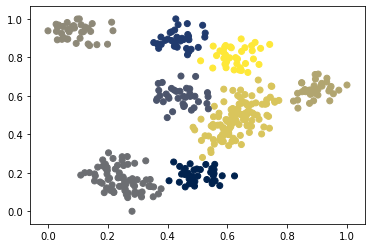

In [26]:
plt.scatter(df_transformed.iloc[:, 0], df_transformed.iloc[:, 1], c=prediction, cmap='cividis')

## 3. Mini-Batch K-Means

In [27]:
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import MiniBatchKMeans

### 3.1. Wyznaczenie optymalnego k

Trzeci z opracowanych przykładów jest poniekąd niewiążącym eksperymentem.
Wydaje mi się, że w przypadku metryki rozważanej na laboratoriach, w której zakładaliśmy dążenie do jak najmniejszych odległości między punktami wewnątrz poszczególnych klastrów, poniekąd 'efektem ubocznym' jest maksymalizacja odległości między środkami poszczególnych klastrów, czyli to aby różne klastry maksymalnie się od siebie różniły. Dlatego też, postanowiłam przetestować bezpośrednio takie podejście. Oczywiście wynik tego 'testu' nie jest wiążący, ze względu na fakt, że przeprowadzamy go na zaledwie jednym zbiorze danych, tym nie mniej chciałam sprawdzić, czy takie podejście w tym konkretnym przypadku jest w stanie doprowadzić do konstruktywnych wyników.

In [34]:
def count_centres_dist(data, kmax):
    scores = []
    k_range = range(2, kmax+1)
    for k in k_range:
        mbkm = MiniBatchKMeans(n_clusters=k)
        mbkm.fit(data)
        dists = euclidean_distances(mbkm.cluster_centers_)
        scores.append(np.median(dists))
    return scores, k_range

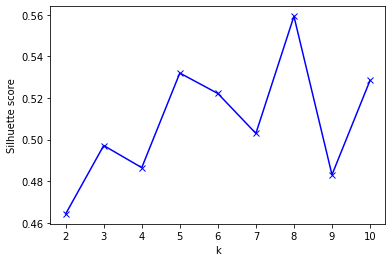

In [31]:
centres_dists, x_ticks = count_silhuette_score(df_transformed, 10)

plt.plot(x_ticks, centres_dists, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhuette score')
plt.show()

Zakładając, że w rozważanym problemie chcemy osiągnąć jak najwyraźniejszy podział - jak największą odległość m-dzy klastrami, wówczas optymalnym k jest 8.

### 3.2. Model

In [32]:
mmbk = MiniBatchKMeans(n_clusters = 8)
# Trenowanie modelu
mmbk.fit(df_transformed)
# Predykcja
prediction = mmbk.predict(df_transformed)

### 3.3. Graficzne przedstawienie przypisania do klastrów 

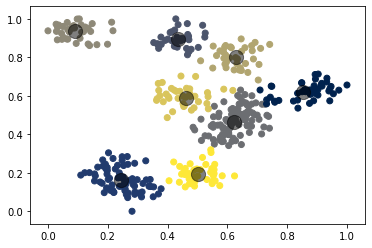

In [33]:
plt.scatter(df_transformed.iloc[:, 0], df_transformed.iloc[:, 1], c=prediction, cmap='cividis')
centers = mmbk.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

Uzyskany w ten sposób podział jest zbliżony to rezultatu uzyskanego w efekcie zastosowania poprzedniego podejścia.